In [183]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
from astropy.io import ascii

from pyia import GaiaData
import gala.coordinates as gc

In [184]:
plt.style.use('notebook')

In [32]:
tall = Table.read('../data/gd1_both.tab', format='ascii.commented_header', delimiter='\t')

In [37]:
tall.colnames

['object',
 'rad',
 'decd',
 'VELOCITY',
 'VELOCITY_1',
 'VELOCITY_2',
 'CZXCR',
 'CZXCR_1',
 'CZXCR_2',
 'rank',
 'type_1']

In [33]:
t = tall[tall['CZXCR']>4]

In [34]:
vbins = np.arange(-200,200,10)

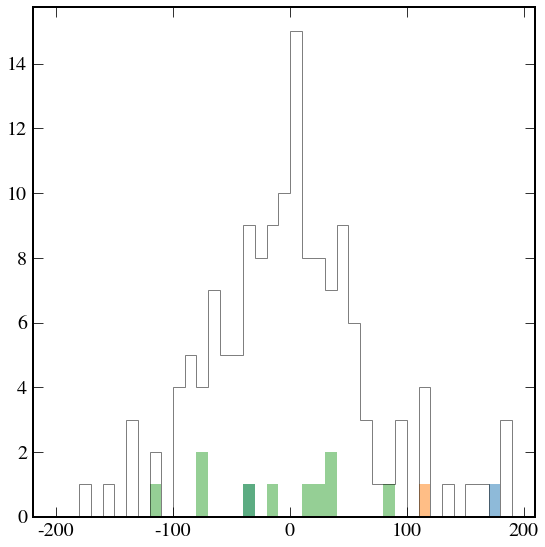

In [35]:
plt.hist(t['VELOCITY'][t['rank']==1], bins=vbins, alpha=0.5)
plt.hist(t['VELOCITY'][t['rank']==3], bins=vbins, alpha=0.5)
plt.hist(t['VELOCITY'][t['rank']==4], bins=vbins, alpha=0.5)

plt.hist(t['VELOCITY'][t['rank']==5], bins=vbins, alpha=0.5, histtype='step', color='k')

plt.tight_layout()

In [45]:
members = (t['rank']<5) & (t['VELOCITY']>-100) & (t['VELOCITY']<-70)
members_alt = (t['rank']<5) & (t['VELOCITY']>-50) & (t['VELOCITY']<-20)

In [46]:
ts = t['VELOCITY', 'CZXCR', 'rank']

In [47]:
ts[ts['rank']==1]

VELOCITY,CZXCR,rank
float64,float64,int64
174.25,5.76,1
-34.0,11.67,1


In [48]:
ts[ts['rank']==4]

VELOCITY,CZXCR,rank
float64,float64,int64
-73.97,14.68,4
85.71,32.53,4
-73.37,8.58,4
-14.0,22.27,4
31.49,40.07,4
31.38,12.22,4
-31.58,10.62,4
16.06,9.33,4
23.5,9.32,4


In [49]:
ts[members]

VELOCITY,CZXCR,rank
float64,float64,int64
-73.97,14.68,4
-73.37,8.58,4


In [50]:
ts[members_alt]

VELOCITY,CZXCR,rank
float64,float64,int64
-34.0,11.67,1
-31.58,10.62,4


In [171]:
ts_all = tall['VELOCITY', 'CZXCR', 'rank']

In [172]:
ts_all[ts_all['rank']<5]

VELOCITY,CZXCR,rank
float64,float64,int64
-73.97,14.68,4
85.71,32.53,4
-73.37,8.58,4
-14.0,22.27,4
174.25,5.76,1
-34.0,11.67,1
319.12,2.78,1
31.49,40.07,4
-29.71,3.72,4


### Position in CMD and proper motions

In [51]:
tin = Table.read('../data/gd1_input_catalog.fits')

In [59]:
g = GaiaData(tin)
c = coord.SkyCoord(ra=g.ra, dec=g.dec, pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [60]:
def gd1_dist(phi1):
    # 0, 10
    # -60, 7
    m = (10-7) / (60)
    return (m*phi1.wrap_at(180*u.deg).value + 10) * u.kpc

In [64]:
gd1_c = c.transform_to(gc.GD1)

gd1_c_dist = gc.GD1(phi1=gd1_c.phi1, phi2=gd1_c.phi2,
                    distance=gd1_dist(gd1_c.phi1),
                    pm_phi1_cosphi2=gd1_c.pm_phi1_cosphi2,
                    pm_phi2=gd1_c.pm_phi2,
                    radial_velocity=[0]*len(gd1_c)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = gd1_c_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
gd1_c = coord.Galactic(rep).transform_to(gc.GD1)

In [65]:
observed = tall['object']

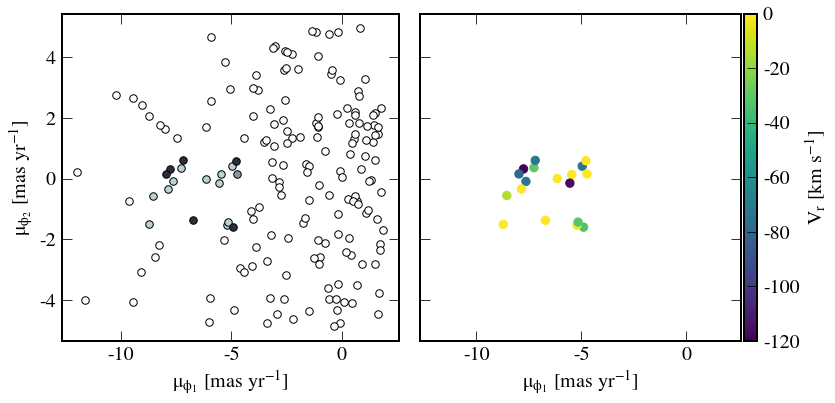

In [178]:
fig, ax = plt.subplots(1,2,figsize=(12,6), sharex=True, sharey=True)

plt.sca(ax[0])
for i in range(5,0,-1):
    ind = tall['rank']==i
    plt.plot(gd1_c.pm_phi1_cosphi2[observed][ind].to(u.mas/u.yr), gd1_c.pm_phi2[observed][ind].to(u.mas/u.yr),
             '.', ms=15, mec='k', mew=1, color=mpl.cm.bone(i/5))

plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

plt.sca(ax[1])
ind = tall['rank']<5
im = plt.scatter(gd1_c.pm_phi1_cosphi2[observed][ind].to(u.mas/u.yr), gd1_c.pm_phi2[observed][ind].to(u.mas/u.yr),
                 c=tall['VELOCITY'][ind], vmin=-120, vmax=0, s=70)

plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="4%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.ylabel('$V_r$ [km s$^{-1}$]')

plt.tight_layout()

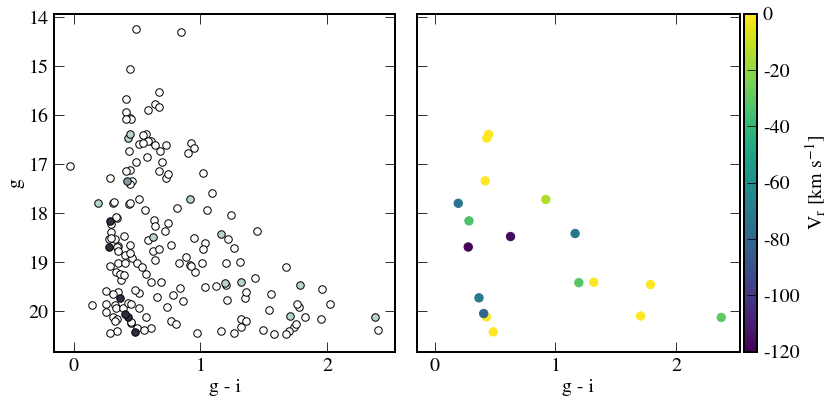

In [175]:
fig, ax = plt.subplots(1,2,figsize=(12,6), sharex=True, sharey=True)

plt.sca(ax[0])
for i in range(5,0,-1):
    ind = tall['rank']==i
    plt.plot(g.g[observed][ind] - g.i[observed][ind], g.g[observed][ind],
             '.', ms=15, mec='k', mew=1, color=mpl.cm.bone(i/5), label='Rank {}'.format(i))

# plt.legend(fontsize='small', handlelength=0.2)
plt.xlabel('g - i')
plt.ylabel('g')

plt.sca(ax[1])
ind = tall['rank']<5
im = plt.scatter(g.g[observed][ind] - g.i[observed][ind], g.g[observed][ind], c=tall['VELOCITY'][ind], 
            vmin=-120, vmax=0, s=70)

# im = plt.scatter(g.g[observed][ind] - g.i[observed][ind], g.g[observed][ind],
#                  c=gd1_c.pm_phi1_cosphi2[observed][ind].to(u.mas/u.yr),
#                  vmin=-15, vmax=-5, s=70)

plt.xlabel('g - i')
plt.gca().invert_yaxis()

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="4%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.ylabel('$V_r$ [km s$^{-1}$]')

plt.tight_layout()

In [130]:
members = ((tall['rank']<5) & (tall['VELOCITY']>-90) & (tall['VELOCITY']<-70) & 
           (tin['g'][observed]-tin['i'][observed]<0.8))

In [138]:
tall['CZXCR'][members]

8.58
3.31
3.17


In [181]:
tall['VELOCITY'][members], np.mean(tall['VELOCITY'][members])

(<Column name='VELOCITY' dtype='float64' length=3>
 -73.37
 -71.82
 -80.78, -75.32333333333334)

In [136]:
g.pmra[observed][members]

<Quantity [-6.59495579, -6.83304654, -7.09828349] marcsec / yr>

In [137]:
g.pmdec[observed][members]

<Quantity [-11.2652454 , -10.45525777, -11.26274454] marcsec / yr>

In [134]:
gd1_c.pm_phi1_cosphi2[observed][members].to(u.mas/u.yr)

<Quantity [-7.63899682, -7.19691191, -7.97087536] mas / yr>

In [135]:
gd1_c.pm_phi2[observed][members].to(u.mas/u.yr)

<Quantity [-0.09032258,  0.60356689,  0.15733172] mas / yr>

In [139]:
cmem = coord.SkyCoord(ra=g.ra[observed][members], dec=g.dec[observed][members],
                      pm_ra_cosdec=g.pmra[observed][members], pm_dec=g.pmdec[observed][members],
                      distance=gd1_dist(gd1_c.phi1[observed][members]),
                      radial_velocity=tall['VELOCITY'][members]*u.km/u.s)

In [144]:
cgal = cmem.transform_to(coord.Galactocentric)
cgal

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in kpc
    [(-12.98926456, 0.62364127, 7.08674843),
     (-12.97248902, 0.6170137 , 7.10048172),
     (-12.93769217, 0.66100661, 7.14507605)]
 (v_x, v_y, v_z) in km / s
    [(-106.33881889, -271.02975429, -114.6178673 ),
     (-118.81622603, -241.52232363, -123.54542864),
     (-118.19946734, -278.82897617, -126.23935049)]>

In [159]:
v = np.linalg.norm([cgal.v_x, cgal.v_y, cgal.v_z], axis=0)*u.km/u.s

In [163]:
vth = np.arcsin(cgal.v_z/v)
vphi = np.arctan2(cgal.v_y, cgal.v_x)

In [179]:
v, vth.to(u.deg), vphi.to(u.deg)

(<Quantity [312.89347647, 296.16515885, 328.10529658] km / s>,
 <Quantity [-21.48859023, -24.65481361, -22.62837931] deg>,
 <Quantity [-111.42261383, -116.19474945, -112.97276095] deg>)

In [180]:
np.std(v), np.std(vth.to(u.deg)), np.std(vphi.to(u.deg))

(<Quantity 13.04440484 km / s>,
 <Quantity 1.30939026 deg>,
 <Quantity 1.98766877 deg>)

In [185]:
kop_vr = ascii.read("""phi1 phi2 vr err
-45.23 -0.04 28.8 6.9
-43.17 -0.09 29.3 10.2
-39.54 -0.07 2.9  8.7
-39.25 -0.22 -5.2 6.5
-37.95 0.00 1.1   5.6
-37.96 -0.00 -11.7 11.2
-35.49 -0.05 -50.4 5.2
-35.27 -0.02 -30.9 12.8
-34.92 -0.15 -35.3 7.5
-34.74 -0.08 -30.9 9.2
-33.74 -0.18 -74.3 9.8
-32.90 -0.15 -71.5 9.6
-32.25 -0.17 -71.5 9.2
-29.95 -0.00 -92.7 8.7
-26.61 -0.11 -114.2 7.3
-25.45 -0.14 -67.8 7.1
-24.86 0.01 -111.2 17.8
-21.21 -0.02 -144.4 10.5
-14.47 -0.15 -179.0 10.0
-13.73 -0.28 -191.4 7.5
-13.02 -0.21 -162.9 9.6
-12.68 -0.26 -217.2 10.7
-12.55 -0.23 -172.2 6.6""")

In [201]:
wangle = 180*u.deg
(np.mean(gd1_c.phi1[observed][members].wrap_at(wangle)),
np.std(gd1_c.phi2[observed][members]),
np.mean(tall['VELOCITY'][members]))

(<Angle -29.87134146 deg>, <Latitude 0.12890834 deg>, -75.32333333333334)

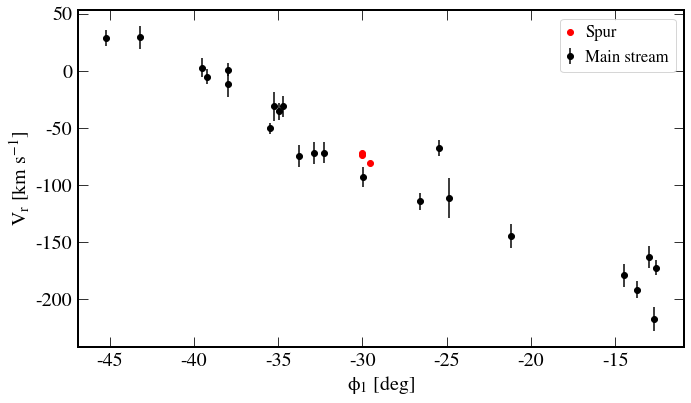

In [202]:
plt.figure(figsize=(10,6))
plt.errorbar(kop_vr['phi1'], kop_vr['vr'], yerr=kop_vr['err'], fmt='o', color='k', label='Main stream')
plt.plot(gd1_c.phi1[observed][members].wrap_at(wangle), tall['VELOCITY'][members], 'ro', label='Spur')

plt.legend(fontsize='small', handlelength=0.3)
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$V_r$ [km s$^{-1}$]')

plt.tight_layout()

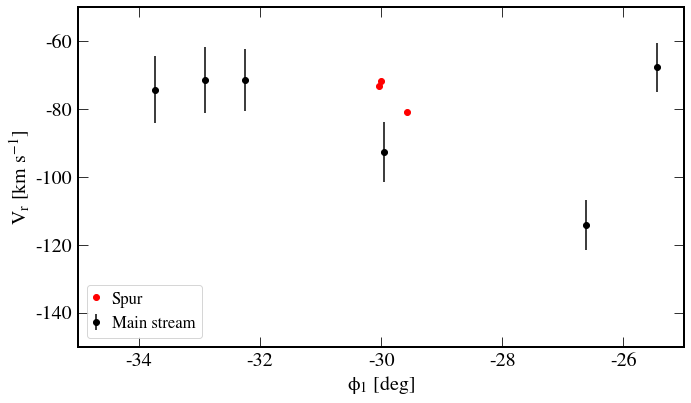

In [203]:
plt.figure(figsize=(10,6))
plt.errorbar(kop_vr['phi1'], kop_vr['vr'], yerr=kop_vr['err'], fmt='o', color='k', label='Main stream')
plt.plot(gd1_c.phi1[observed][members].wrap_at(wangle), tall['VELOCITY'][members], 'ro', label='Spur')

plt.legend(fontsize='small', handlelength=0.3)
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$V_r$ [km s$^{-1}$]')

plt.xlim(-35,-25)
plt.ylim(-150,-50)

plt.tight_layout()